In [3]:
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
import numpy as np
import pandas as pd 
from os import path
from numpy.linalg import norm
import os 
import csv 
from cmaps import *

alex_dir = "../../data/Alex_Data/"

def get_dir(thermal, l, delta, beta):
	fn = "Thermal_Data" if thermal else "Zero_Temp_Data"

	if thermal:
		fn = path.join(fn, 
				f"Cormat_Data_L={l}_Delta={delta}_Spectral_Depth=20_beta={beta}")
	else: 
		fn = path.join(fn, f"Cormat_Data_L={l}_Delta={delta}")

	fn = path.join(alex_dir, fn)

	return fn


def get_eigen(thermal, l, delta, beta, trunc):
	fn = get_dir(thermal, l, delta, beta)
	fn = path.join(fn, f"Truncations={trunc}")
	evecs = np.genfromtxt(path.join(fn, 'Eigvecs.txt'), delimiter='\t')
	evals = np.genfromtxt(path.join(fn, 'Eigvals.txt'), delimiter='\t')
	
	if np.shape(evals) == (): 
		evals = np.array([evals])
	return evals, evecs


def get_hamiltonian(l, delta, beta): 
	fn = get_dir(True, l, delta, beta)
	fn = path.join(fn, "Extra_Data")

	h = np.genfromtxt(path.join(fn, 'Hvec.txt'), delimiter='\t')
	
	return h 

def get_boltzmann(l, delta, beta): 
	fn = get_dir(True, l, delta, beta)
	fn = path.join(fn, "Extra_Data")

	h = np.genfromtxt(path.join(fn, 'Boltzmann_weights.txt'), delimiter='\t')
	
	return h 


def get_spectrum(l, delta, beta):
	fn = get_dir(True, l, delta, beta)
	fn = path.join(fn, "Extra_Data")

	h = np.genfromtxt(path.join(fn, 'Raw_Spectrum.txt'), delimiter='\t')
	
	return h 
	

betas = [1000, 100, 50, 10]
truncs = np.arange(9)
truncs

In [4]:
l = 18
delta = 2

betas = np.arange(0.5, 5.0, 0.5)
print(betas)

truncs = np.arange(2, int(l / 2))

print(truncs)

lowest_evals_beta = []
for beta in betas: 
    lowest_evals = []
    for trunc in truncs: 
        try:
            evals, evecs = get_eigen(True, l, delta, beta, trunc)
            lowest_evals.append(evals[0])
        except Exception as err:
            print(f'Error processing beta={beta}, trunc={trunc}')
            print(Exception, err)
            
    lowest_evals_beta.append(lowest_evals)

zero_temp_evals = []
for trunc in truncs:
	evals, evecs = get_eigen(False, l, delta, beta, trunc)
	zero_temp_evals.append(evals[0])

[0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5]
[2 3 4 5 6 7 8]


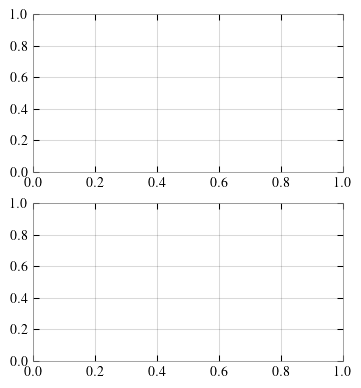

In [5]:
fig, ax = plt.subplots(figsize=(4, 4.5), nrows=2)

In [6]:
# cmap = mpl.colormaps['plasma'].reversed()
cmap_thermal = get_continuous_cmap([
    '#4838a8', 
    '#cb4679', 
    '#f2ec5e',
    ]).reversed()

norm_thermal = mpl.colors.Normalize(vmax=betas[-1], vmin=betas[0])

In [7]:
r = np.linspace(truncs[0], truncs[-1], 100)

ax[0].plot(r, 2.5 * zero_temp_evals[-1] / np.power(r, 2 * delta), color='grey', 
        	linestyle='dashed', alpha=0.85)

for b, ev in zip(np.flip(betas), np.flip(lowest_evals_beta, axis=0)):
    ax[0].scatter(np.flip(truncs), ev,
               color=cmap_thermal(norm_thermal(b)), alpha=0.8)

# NOTE: should say \beta = \infty? maybe instead say "pure state" 
ax[0].scatter(np.flip(truncs), zero_temp_evals, label=f'$\\beta = \\infty$', 
           color='black', alpha=0.4)


In [8]:
ax[0].set_xticks(truncs)
ax[0].set_xlabel('$ N $ operators')
ax[0].set_ylabel('$ \lambda_0 $')

Text(4.444444444444448, 0.5, '$ \\lambda_0 $')

In [9]:

cbar = fig.colorbar(cm.ScalarMappable(norm=norm_thermal, cmap=cmap_thermal), location='right', 
                    ticks=betas, ax=ax[0])
cbar.set_label('$\\beta\\Delta E$')
cbar.ax.tick_params(size=2)

ax[0].text(0.04, 0.175, '(a)', transform=ax[0].transAxes,
		fontsize=14, va='top')

Text(0.04, 0.175, '(a)')

In [10]:
import matplotlib.ticker as mticker 

ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xticks(truncs)

# Do not use scientific notation for x axis
ax[0].xaxis.set_major_formatter(mticker.ScalarFormatter())

ax[0].legend(frameon=False, loc=(0.1, 0.045))

In [11]:
spec = get_spectrum(l, delta, betas[0])
gap = spec[1] - spec[0]

beta_cont = np.linspace(betas[0], betas[-1], 100)
boltz_function = 4.5 * np.exp(- gap * beta_cont) 
boltz = get_boltzmann(l, delta, betas[-1])


ax[1].plot(beta_cont, boltz_function, color='grey', linestyle='dashed', alpha=0.85, 
	   		label='$e^{-\\beta\Delta E}$')

cmap = get_continuous_cmap([
	'#632a70',
	'#534699', 
	'#3b739c',
	'#21908d',
	'#35b779',
	'#94cf55',
	'#eddd47'
	]).reversed().resampled(len(truncs))
# cmap = mpl.colormaps['viridis'].reversed().resampled(len(truncs))

norm = mpl.colors.Normalize(vmax=truncs[-1], vmin=truncs[0])

i = 0
for n_ops in np.flip(truncs):
	ax[1].scatter(betas, np.transpose(lowest_evals_beta)[i] - zero_temp_evals[i],
	    # label=f'$\\text{{Truncs.}} = {t}$', 
		alpha=0.8,
		color=cmap(norm(n_ops)))
	i += 1

ax[1].legend()
# ax.set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('$\\beta\\Delta E$')
ax[1].legend(frameon=False, loc='upper right')
ax[1].set_ylabel('$\lambda_{0, \\beta} - \lambda_{0, \\beta = \infty}$')

# ax[1].set_ylim(1.7e-5, 1e2)


ax[1].text(0.04, 0.175, '(b)', transform=ax[1].transAxes,
		fontsize=14, va='top')


Text(0.04, 0.175, '(b)')

In [12]:
cbar = fig.colorbar( cm.ScalarMappable(norm=norm, cmap=cmap), location='right', 
		    ticks=np.arange(2, 9), ax=ax[1])
cbar.set_label('$N$ operators')
cbar.ax.tick_params(size=0)


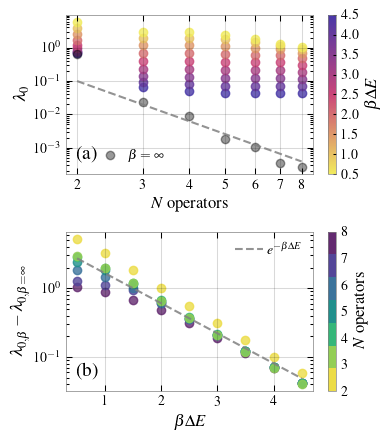

In [13]:
fig.tight_layout()
fig

In [14]:
fig.savefig('../drafts/thermal_plot_v0.pdf')
fig.savefig('../drafts/thermal_plot_v0.png')
fig.get_size_inches() * fig.dpi

array([400., 450.])